# Online Retail

### UC Irvine Machile Learning Repository:  
- source: https://archive.ics.uci.edu/dataset/352/online+retail
- github repository:

This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

Dataset Information

This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, silhouette_samples,davies_bouldin_score, calinski_harabasz_score
#!pip install clusteval
from collections import defaultdict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load dataset
raw_online_retail = pd.read_csv('/content/drive/MyDrive/online_retail.csv', low_memory=False,skiprows=1)

In [ ]:
raw_online_retail.shape

(541909, 8)

In [ ]:
raw_online_retail.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Check duplicated rows
len(raw_online_retail[raw_online_retail.duplicated])

5268

In [ ]:
# Delete duplicate rows
online_retail_2_miss=raw_online_retail.drop_duplicates(keep='last',inplace=False)

In [ ]:
n_rows, n_cols = online_retail_2_miss.shape
print(n_rows, n_cols)

536641 8


In [ ]:
# Check for missing values
print(online_retail_2_miss.isna().values.any())
print(online_retail_2_miss.isnull().values.any())

True
True


In [ ]:
# Check missing values percetage
n_missing_description=online_retail_2_miss['Description'].isnull().sum()
print('Missing fields in Description column:',round((n_missing_description*100)/n_rows,2),'%',n_missing_description)

Missing fields in Description column: 0.27 % 1454


In [ ]:
n_missing_customer=online_retail_2_miss['CustomerID'].isnull().sum()
print('Missing fields in CustomerID column:',round((n_missing_customer*100)/n_rows,2),'%',n_missing_customer)

Missing fields in CustomerID column: 25.16 % 135037


In [ ]:
# Handle missing values CustomerID
online_retail_1_miss = online_retail_2_miss.dropna(subset=['CustomerID'],inplace=False)

In [ ]:
# Handle missing values in Description
online_retail_noise = online_retail_1_miss.dropna(subset=['Description'],inplace=False)

In [ ]:
# Dropping not valuable columns
online_retail = online_retail_noise.drop(['InvoiceNo','StockCode','Description'],axis=1,inplace=False)

In [ ]:
online_retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Quantity     401604 non-null  int64  
 1   InvoiceDate  401604 non-null  object 
 2   UnitPrice    401604 non-null  float64
 3   CustomerID   401604 non-null  float64
 4   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 18.4+ MB


In [ ]:
# Separate InvoiceDate
online_retail['InvoiceDate'] = pd.to_datetime(online_retail['InvoiceDate'], format='%m/%d/%y %H:%M')
# Extract Date and Time separately
online_retail['Invoice_Date'] = online_retail['InvoiceDate'].dt.date      # Extract Date
online_retail['Invoice_Time'] = online_retail['InvoiceDate'].dt.time      # Extract Time
online_retail.head(2)
online_retail_sep=online_retail.drop(['InvoiceDate'],axis=1,inplace=False)

In [ ]:
#Handle data types
online_retail_sep['Country'] = online_retail_sep['Country'].astype(str)

In [ ]:
# Find the latest purchase date in the dataset
online_retail_sep['Invoice_Date'] = pd.to_datetime(online_retail_sep['Invoice_Date'], format='%m/%d/%y')
latest_date = online_retail_sep['Invoice_Date'].max()

# Compute Recency: Days since last purchase
recency_df = online_retail_sep.groupby('CustomerID').agg({'Invoice_Date': 'max'}).reset_index()
recency_df['Recency'] = (latest_date - recency_df['Invoice_Date']).dt.days
recency_df.drop(columns=['Invoice_Date'], inplace=True)  # Remove InvoiceDate column

In [ ]:
online_retail_sep['Total_Spend'] = online_retail_sep['Quantity'] * online_retail_sep['UnitPrice']  # Compute total spend per transaction

# Create customer_df with other attributes
customer_df = online_retail_sep.groupby('CustomerID').agg({
    'Quantity': 'sum',         # Total quantity bought
    'Total_Spend': 'sum',      # Total money spent
    'Country': 'first'         # Keep customer's country
}).reset_index()

# Merge Recency into customer_df
customer_df = customer_df.merge(recency_df, on='CustomerID', how='left')
customer_df.head()

,CustomerID,Quantity,Total_Spend,Country,Recency
0,12346.0,0,0.00,United Kingdom,325
1,12347.0,2458,4310.00,Iceland,2
2,12348.0,2341,1797.24,Finland,75
3,12349.0,631,1757.55,Italy,18
4,12350.0,197,334.40,Norway,310


In [ ]:
customer_df.shape

(4372, 5)

In [ ]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CustomerID   4372 non-null   float64
 1   Quantity     4372 non-null   int64  
 2   Total_Spend  4372 non-null   float64
 3   Country      4372 non-null   object 
 4   Recency      4372 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 170.9+ KB


In [ ]:
# Delete CustomerID from dataset
customer_df.drop('CustomerID',axis=1,inplace=True)

In [ ]:
# Encoding
customer_df_encoded = pd.get_dummies(customer_df, columns=['Country'], drop_first=True).astype(int)

In [ ]:
customer_df_encoded.head(2)

,Quantity,Total_Spend,Recency,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,0,0,325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2458,4310,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# check on normal distribution
def isNormalDistributed(df,column):
    # Perform the Shapiro-Wilk test
    stat, p = shapiro(df[column])
    #print('Statistics=%.3f, p=%.3f' % (stat, p))
    # Interpretation of result
    if p > 0.05:
        print(column+ " is normally distributed")
    else:
        print(column+ " is not normally distributed")
#Plotting a histogram and a boxplot to show outliers
def hist_boxplot(df,column):
    # Generate sample continuous data
    data = df[column]

    # Create a figure with a shared axis for the histogram and box plot
    fig, ax = plt.subplots(2, 1, figsize=(4, 3), gridspec_kw={'height_ratios': [1, 4]})

    # Box plot (at the top)
    sns.boxplot(x=data, ax=ax[0], orient='h', color='skyblue')
    ax[0].set(xlabel='')

    # Histogram (at the bottom)
    ax[1].hist(data, bins=30, color='skyblue', edgecolor='black',density=True)
    ax[1].set_xlabel('Values')
    ax[1].set_ylabel('Density')

    # Title
    plt.suptitle('Fig. Boxplot and Histogram Column '+str(column))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Quantity is not normally distributed


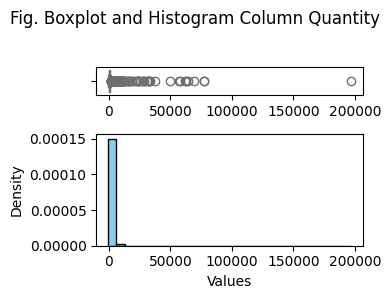

Total_Spend is not normally distributed


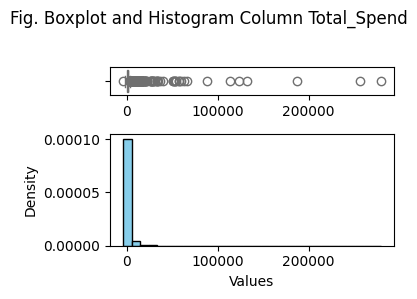

Recency is not normally distributed


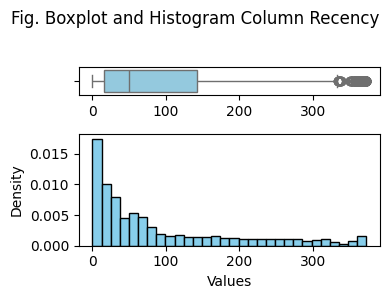

In [ ]:
from scipy.stats import shapiro #determining distributions
for c in ['Quantity','Total_Spend','Recency']:
    isNormalDistributed(customer_df,c)
    hist_boxplot(customer_df,c)

In [ ]:
scaler = MinMaxScaler()
customer_df_encoded[['Quantity', 'Total_Spend','Recency']] = scaler.fit_transform(customer_df_encoded[['Quantity', 'Total_Spend','Recency']])

In [ ]:
customer_df_scaled = customer_df_encoded.copy()
customer_df_scaled.head(3)

,Quantity,Total_Spend,Recency,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,0.001538,0.015107,0.871314,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.014014,0.030295,0.005362,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.013420,0.021439,0.201072,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
customer_df_scaled.shape

(4372, 39)

## Dimensionally Reduction

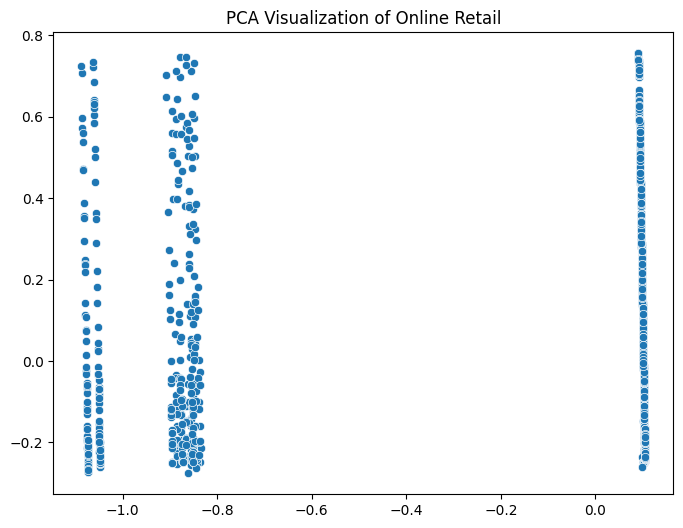

In [ ]:
#Dimensionality Reduction using PCA
pca = PCA(n_components=2)
df1_pca = pca.fit_transform(customer_df_scaled)

# Visualize Dataset_1 PCA Results
plt.figure(figsize=(8,6))
sns.scatterplot(x=df1_pca[:, 0], y=df1_pca[:, 1])
plt.title("PCA Visualization of Online Retail")
plt.show()

## Clustering Implementation

In [ ]:
data = np.array(df1_pca, dtype=float)  # Ensure numerical format

In [ ]:
# Gaussian Kernel function for d-dimensional data
def gaussian_kernel(z, d):
    return (2*np.pi)**(d/2)* np.exp(-0.5 * np.linalg.norm(z, axis=1) ** 2)

def density_estimation_f(x,D,h):
    n = D.shape[0]
    d = D.shape[1]

    return 1/(n*(h**d))*np.sum(gaussian_kernel((x - D) / h, d))

# FindAttractor function for d-dimensional data
def find_attractor(x, D, h, epsilon=1e-3, max_iter=1000):
    x_t = np.array(x, dtype=float)
    d = D.shape[1]  # Get dimensionality


    for t in range(max_iter):
        # Compute distances and weights
        z = (x_t - D) / h

        #weights is an array
        weights = gaussian_kernel(z, d)

        # Compute density-weighted mean
        numerator = np.sum(weights[:, np.newaxis] * x_t, axis=0)
        denominator = np.sum(weights)

        x_t_next = numerator/denominator  if denominator != 0 else x_t

        # Convergence check
        if np.linalg.norm(x_t_next - x_t) <= epsilon:
            x_t = x_t_next
            break
        x_t = x_t_next

    return x_t  # Round to avoid floating-point precision errors

import numpy as np
from scipy.spatial.distance import cdist

def find_density_connected_components(attractors, epsilon):
    """
    Identifies maximal density-connected clusters in DENCLUE.

    Parameters:
        attractors: np.ndarray (n, d) - Converged attractor points
        epsilon: float - Maximum distance for density reachability

    Returns:
        clusters: list of lists - Each list contains indices of points in the same cluster
    """
    n = len(attractors)
    visited = np.zeros(n, dtype=bool)  # Track visited points
    clusters = []  # Store clusters

    def density_reachable(idx, cluster):
        """Recursively find density-reachable points."""
        visited[idx] = True
        st = [idx]
        while st:
            current = st.pop()
            cluster.append(current)
            neighbors = np.where(cdist([attractors[current]], attractors)[0] <= epsilon)[0]
            for neighbor in neighbors:
                if visited[neighbor]:
                    continue

                visited[neighbor] = True
                st.append(neighbor)

    for i in range(n):
        if not visited[i]:
            new_cluster = []
            density_reachable(i, new_cluster)
            if len(new_cluster) > 1:  # Ensure meaningful clusters
                clusters.append(new_cluster)

    return clusters


def refine_clusters(clusters, attractors, R, epsilon):
    """
    Expands density-based clusters by ensuring all reachable points are included.

    Parameters:
        clusters: list of lists - Initial clusters with density-connected points
        attractors: np.ndarray (n, d) - Attractor points
        epsilon: float - Maximum distance for density reachability

    Returns:
        refined_clusters: list of lists - Expanded clusters
    """
    for cluster in clusters:
        expanded_cluster = set(cluster)  # Convert to set for efficient merging

        # Iterate through all points in the cluster
        for idx in list(expanded_cluster):
            # Find all points within epsilon distance
            # neighbors = np.where(cdist([attractors[idx]], attractors)[0] <= epsilon)[0]
            expanded_cluster.update(R[tuple(attractors[idx])])  # Merge density-reachable points

        cluster[:] = list(expanded_cluster)  # Update cluster in place

    return clusters


def denclue(D, h, density_threshold, epsilon=1e-3):
    A = set() #set
    R = defaultdict(set) #dict
    clusters = {}
    labels = np.full(len(D), -1)  # Initialize all points as noise (-1)
    d = D.shape[1]  # Get dimensionality

    for idx, x in enumerate(D):
        x_star = find_attractor(x, D, h, epsilon)

        if density_estimation_f(x_star,D,h) >=density_threshold:
            A.add(tuple(x_star))
            R[tuple(x_star)].add(idx)

    A = np.array(list(A))
    C = find_density_connected_components(A,density_threshold)
    C = refine_clusters(C, A, R, density_threshold)
    L = assign_labels(D,C)
    return C, L


def assign_labels(D, clusters):
    """
    Assigns cluster labels to each attractor point.

    Parameters:
        attractors: np.ndarray (n, d) - Attractor points
        clusters: list of lists - Clustered point indices

    Returns:
        labels: np.ndarray (n,) - Cluster labels for each point
    """
    labels = np.full(len(D), -1)  # Default: noise (-1)

    for cluster_id, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = cluster_id  # Assign cluster ID

    return labels


In [ ]:
def plot_scatter_kde(x_grid,kde_values,x_values,bandwidth):
    plt.figure(figsize=(8, 4))
    plt.plot(x_grid, kde_values, 'k-', linewidth=1)  # Density curve
    plt.scatter(x_values, np.zeros_like(x_values), color='blue')  # Data points at bottom
    plt.xlabel("")
    plt.ylabel("f(x)")
    plt.title("Density Estimation h = "+str(bandwidth))

    plt.show()

# KDE Density Estimation for 3D Surface Plot
def plot_3DSurface(data,bandwidth):
    x_values, y_values = data[:, 0], data[:, 1]
    kde = gaussian_kde(np.vstack([x_values, y_values]), bw_method=bandwidth)

    x_grid, y_grid = np.meshgrid(np.linspace(min(x_values)-0.2, max(x_values)+0.5, 200),
                                 np.linspace(min(y_values)-0.2, max(y_values)+0.5, 200))
    z_values = kde(np.vstack([x_grid.ravel(), y_grid.ravel()])).reshape(x_grid.shape)

    # 3D Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_values, y_values, np.zeros_like(x_values), color='blue')
    ax.plot_surface(x_grid, y_grid, z_values, edgecolor='gray', cmap='viridis')
    ax.set_xlabel("Component 1 (cm)")
    ax.set_ylabel("Component 2 (cm)")
    ax.set_zlabel("f(x)")
    ax.set_title("3D Density Estimation h = "+str(bandwidth))
    plt.show()

In [ ]:
data = np.array(df1_pca, dtype=float)  # Ensure numerical format
print(len(data))

4372


In [ ]:
# Denclue Parameters
bandwidth = 0.6 # Smoothness parameter #deacreasing bandwidth ->  Reduce  0.8
density_threshold = 0.080  # Minimum points per cluster #decreasing density_threshold -> Increase the number of clusters # 0.010

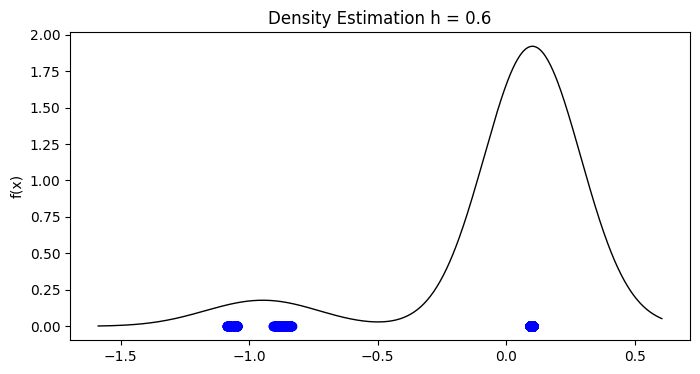

In [ ]:
# KDE Density Estimation and Plot
x_values = data[:, 0]
y_values = data[:,1]
kde = gaussian_kde(x_values, bw_method=bandwidth)
x_grid = np.linspace(min(x_values) - 0.5, max(x_values) + 0.5, 700)
kde_values = kde(x_grid)
plot_scatter_kde(x_grid,kde_values,x_values,bandwidth)



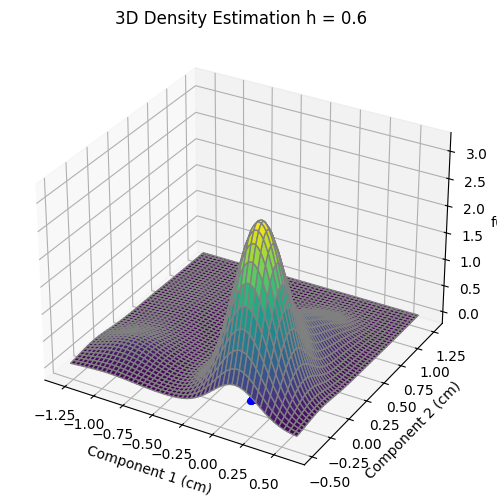

In [ ]:
plot_3DSurface(data,bandwidth)


In [ ]:
clusters,labels = denclue(data, bandwidth, density_threshold)

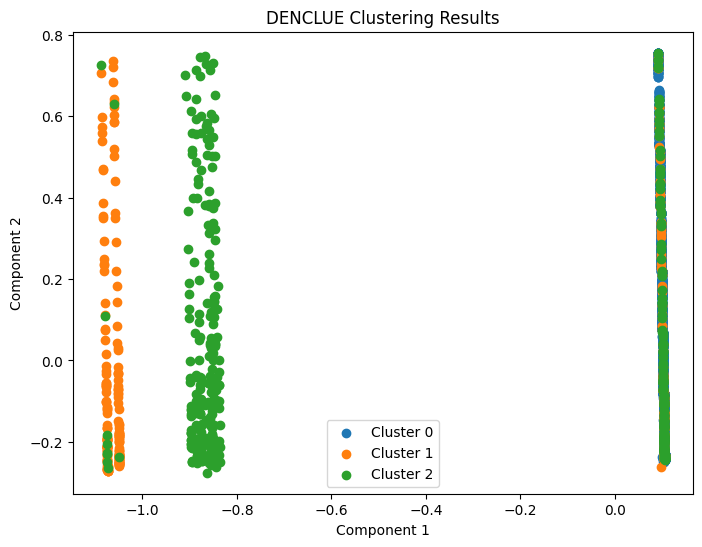

In [ ]:
def plot_clusters(data, labels):
    """
    Plots the clusters from the given data and labels.

    Parameters:
    - data: numpy array of shape (n_samples, n_features)
    - labels: numpy array of shape (n_samples,)
    """
    unique_clusters = np.unique(labels)

    plt.figure(figsize=(8, 6))

    for cluster in unique_clusters:
        cluster_data = data[labels == cluster]

        if cluster == -1:
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label="Noise", c="gray", marker="x")
        else:
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {cluster}")

    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("DENCLUE Clustering Results")
    plt.legend()
    plt.show()
plot_clusters(data, labels)


In [ ]:
# Function to tune parameters and store results in a table
def tune_denclue_parameters(data, bandwidth_values, density_threshold_values):
    results = []

    for h in bandwidth_values:
        for xi in density_threshold_values:
            clusters, labels = denclue(data, h, xi)

            # Convert clusters to labels
            #labels = np.full(len(data), -1)  # Initialize all points as noise (-1)
            #for cluster_id, points in enumerate(clusters):
            #    points_array = np.array([data[p] for p in points])
            #    for point in points_array:
            #        index = np.where((data == point).all(axis=1))[0]
            #        if index.size > 0:
            #            labels[index[0]] = cluster_id

            # Compute DBI
            try:
                dbi = davies_bouldin_score(data, labels)
            except:
                dbi = float('inf')  # Assign infinite DBI if computation fails

            results.append({"Bandwidth (h)": h, "Density Threshold (ξ)": xi, "Clusters Found": len(clusters), "DBI": dbi})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Define parameter ranges for tuning
# bandwidth_values = [0.77,0.8,0.83]  # Different bandwidths to test
# density_threshold_values = [0.01,0.011,0.013]  # Different density thresholds to test
bandwidth_values = [0.2,0.4,0.6]  # Different bandwidths to test
density_threshold_values = [0.008,0.08,0.2,0.5,0.6]  # Different density thresholds to test

# Call the tuning function
results_df = tune_denclue_parameters(df1_pca, bandwidth_values, density_threshold_values)


In [ ]:
results_df.sort_values(by='DBI', ascending=True).head(20)

,Bandwidth (h),Density Threshold (ξ),Clusters Found,DBI
2,0.2,0.200,2,0.588405
3,0.2,0.500,2,0.588405
4,0.2,0.600,2,0.588405
7,0.4,0.200,2,1.449070
8,0.4,0.500,2,1.449070
9,0.4,0.600,2,1.449070
12,0.6,0.200,2,1.456001
13,0.6,0.500,2,1.456001
14,0.6,0.600,2,1.456001
1,0.2,0.080,3,2.140036


In [ ]:
# Compute Silhouette Score
score = silhouette_score(data, labels)
print("Silhouette Score:", score)
# Compute Davies-Bouldin Index
dbi_score = davies_bouldin_score(data, labels)
print("Davies-Bouldin Index:", dbi_score)

# 0 to 1	Very good clustering (compact & well-separated).
# 1 to 2	Moderate clustering quality.
#>2	Poor clustering (overlapping, noisy, or poorly defined clusters).
# Unlike the Silhouette Score, DBI is not affected by noise points.
# Compute CH Index
ch_score = calinski_harabasz_score(data, labels)
print("Calinski-Harabasz Index:", ch_score)

#CH Index Value	Interpretation
#Low (e.g., < 100)	Poor clustering, clusters are not well-separated
#Moderate (100–1000)	Acceptable clustering quality
#High (1000+ or higher)	Strong clustering, well-separated groups

#The Gap Statistic is designed for clustering methods that use a fixed number
# of clusters (like K-Means). However, DENCLUE does not require pre-defining
# the number of clusters, which makes traditional Gap Statistic less effective.

Silhouette Score: 0.4478835603385847
Davies-Bouldin Index: 7.076905889241097
Calinski-Harabasz Index: 824.7977152144747
